# Demographics

In [89]:
#imports
import pandas as pd
import matplotlib.pyplot as plt

In [90]:
# set project root
import os
os.chdir('../..')

In [91]:
# Important! Set project root as current working directory first
from src.utils import get_project_root

root = get_project_root()
os.chdir(root)

In [92]:
index_col='answer_id'
date_cols=['sensordata_collected_at']

# Define a custom parser function for Unix timestamps
date_parser = lambda x: pd.to_datetime(float(x), unit='s')

# read in Baseline
bl = pd.read_csv('data/d01_raw/rki_heart_baseline.csv', index_col=index_col)

# read in FollowUp
fu = pd.read_csv('data/d01_raw/rki_heart_followup.csv', index_col=index_col)

## General facts about the datasets
### Baseline

In [93]:
print('Number of users and columns:\t', bl.shape)

Number of users and columns:	 (1805, 88)


### Follow Up

In [94]:
fu.shape

(5895, 55)

## Distribution of demographics

### Age


In [95]:
bins = [10, 14, 17, 30, 40, 50, 60, 70, 80, 90, 120]
bl['age_decades'] = pd.cut(bl.alter, bins=bins)
res = pd.crosstab(bl.age_decades, bl.geschlecht)
res.to_csv('results/tables/age-by_sex.csv')
res

geschlecht,0.0,1.0,2.0
age_decades,,,
"(17, 30]",141,45,1
"(30, 40]",109,49,0
"(40, 50]",81,48,1
"(50, 60]",75,55,1
"(60, 70]",23,39,0
"(70, 80]",4,9,0
"(80, 90]",0,1,0
"(90, 120]",0,2,0


In [96]:
bl.alter.describe()

count    684.000000
mean      41.682749
std       15.093178
min       18.000000
25%       30.000000
50%       40.000000
75%       53.000000
max      120.000000
Name: alter, dtype: float64

In [97]:
# follow-up
fu_users = fu.user_id.unique().tolist()
bl[bl['user_id'].isin(fu_users)].alter.describe()

count    337.000000
mean      43.919881
std       14.800342
min       18.000000
25%       32.000000
50%       43.000000
75%       55.000000
max      107.000000
Name: alter, dtype: float64

## Country

In [98]:
bl.country.value_counts()

country
DEU    675
AUT      3
MEX      1
GBR      1
AND      1
NLD      1
FRA      1
ATG      1
Name: count, dtype: int64

In [99]:
bl.country.value_counts(normalize=True)

country
DEU    0.986842
AUT    0.004386
MEX    0.001462
GBR    0.001462
AND    0.001462
NLD    0.001462
FRA    0.001462
ATG    0.001462
Name: proportion, dtype: float64

In [100]:
bl[bl['user_id'].isin(fu_users)].country.value_counts(normalize=True)

country
DEU    0.988131
MEX    0.002967
GBR    0.002967
AND    0.002967
NLD    0.002967
Name: proportion, dtype: float64

## Sex

In [101]:
bl.geschlecht.value_counts(normalize=True)

geschlecht
0.0    0.633041
1.0    0.362573
2.0    0.004386
Name: proportion, dtype: float64

## FollowUp behaviour

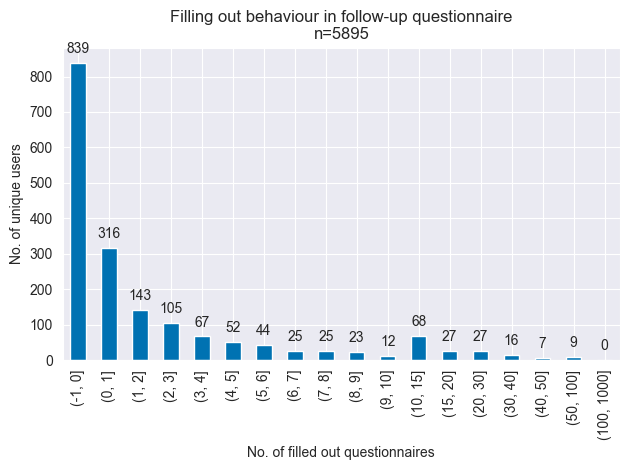

In [102]:
bins = [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,15, 20, 30, 40, 50, 100, 1000]
user_cnt = fu.user_id.value_counts()
ser = pd.cut(user_cnt, bins).value_counts().sort_index()
ser.iloc[0] = bl.shape[0]-fu.user_id.nunique()
ax = ser.plot(kind='bar')

# Adding data labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Adding title and labels
plt.title('Filling out behaviour in follow-up questionnaire\nn=5895')
plt.xlabel('No. of filled out questionnaires')
plt.ylabel('No. of unique users')

plt.tight_layout()

plt.savefig('results/figures/filling_out_behaviour.svg')
# Display the plot
plt.show()

## When did users join the study?

Number of monthly active users in baseline


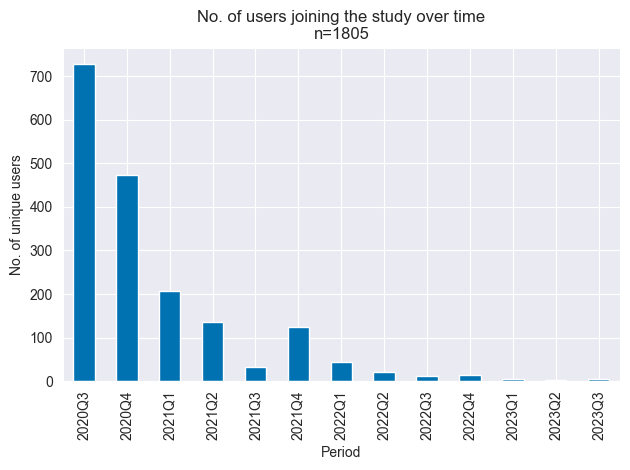

In [103]:
print('Number of monthly active users in baseline')
bl.created_at = pd.to_datetime(bl.created_at)
bl['YYYY-MM'] = bl.created_at.dt.strftime('%Y-%m')
bl['Q'] = bl.created_at.dt.to_period('Q')
bl.groupby('Q').nunique()['user_id'].plot(kind='bar')

# Adding title and labels
plt.title('No. of users joining the study over time\nn=1805')
plt.xlabel('Period')
plt.ylabel('No. of unique users')

plt.tight_layout()

plt.savefig('results/figures/users_joining_periods.svg')
# Display the plot
plt.show()

### Figure that shows how many questionnaires from how many users, grouped by bl and fu we had in the study

In [104]:
# read in other data source to correlate with our users from the app
df_cases = pd.read_csv('data/d01_raw/data.csv')

# convert to datetime to process further to 'Q' periods
df_cases.time_iso8601 = pd.to_datetime(df_cases.time_iso8601, utc=True)
df_cases['Q'] = df_cases.time_iso8601.dt.to_period('Q')

C:\Users\joa24jm\AppData\Local\Temp\ipykernel_16172\1004125611.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_cases['Q'] = df_cases.time_iso8601.dt.to_period('Q')


In [105]:
# add information where this questionnaire comes from
fu['questionnaire'] = 'fu'
bl['questionnaire'] = 'bl'

# merge questionnaires
df = pd.concat([bl, fu])
df.created_at = pd.to_datetime(df.created_at)
df['Q'] = df.created_at.dt.to_period('Q')

In [106]:
# TODO Create that figure of new cases in this period
df_cases['new_cases']= df_cases['sum_cases'].diff()
ser = df_cases.groupby('Q')['new_cases'].sum().astype(int)
ser

Q
2020Q1      70275
2020Q2     122952
2020Q3      96243
2020Q4    1365021
2021Q1    1173705
2021Q2     906715
2021Q3     478322
2021Q4    2883024
2022Q1    6556988
Freq: Q-DEC, Name: new_cases, dtype: int32

In [107]:
res = df.groupby(['Q', 'questionnaire']).size()
# Unstack the DataFrame to make it suitable for a stacked bar chart
df_unstacked = res.unstack(level='questionnaire').fillna(0)

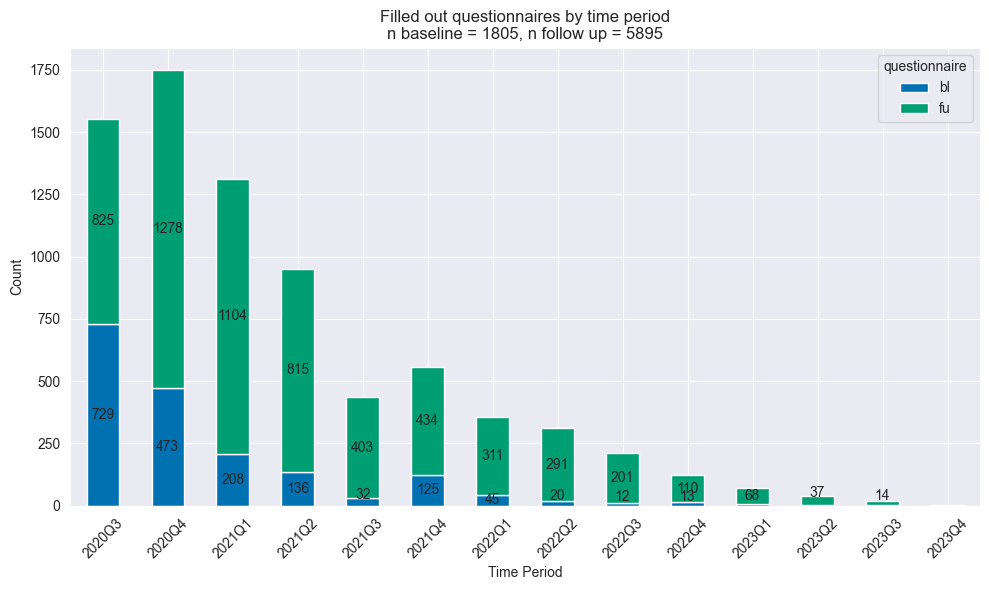

In [108]:
# set style
plt.style.use('seaborn-v0_8-colorblind')

# create fig
ax = res.unstack(level='questionnaire').plot(kind='bar', stacked=True, figsize=(10, 6))
ax.set_title('Filled out questionnaires by time period\nn baseline = 1805, n follow up = 5895')
ax.set_xlabel('Time Period')
ax.set_ylabel('Count')

# Adding data labels
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    label_text = f'{int(height)}'

    # Check if the height of the bar is enough to fit the label
    if height > 40:  # You can adjust this threshold based on your typical data scale and aesthetics
        ax.text(x + width/2, y + height/2, label_text, ha='center', va='center')
    elif height > 10:
        ax.text(x + width/2, y + height/2, label_text, ha='center', va='bottom')
    else:
        pass


## Convert Period index to datetime if necessary
#if isinstance(res.index, pd.PeriodIndex):
#    res.index = res.index.to_timestamp()
#ax.plot(ser, color='red', marker='o', linestyle='-', linewidth=2.0, label='Line Plot Label')

plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('results/figures/n_assessments_by_Q_and_kind.svg')

plt.show()

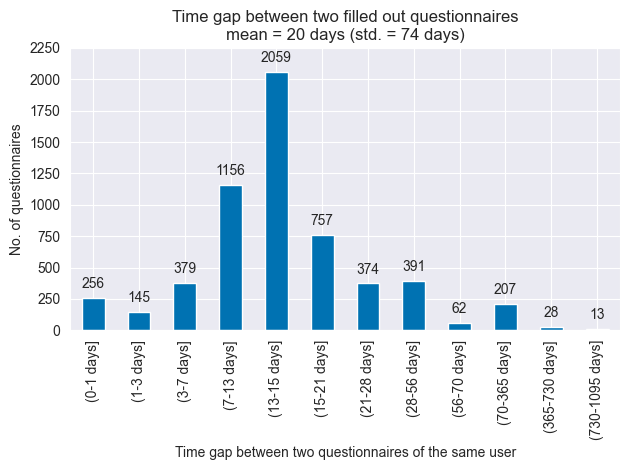

In [109]:
# Define bins
bins = [pd.Timedelta(days=0), pd.Timedelta(days=1), pd.Timedelta(days=3), pd.Timedelta(days=7),
        pd.Timedelta(days=13), pd.Timedelta(days=15), pd.Timedelta(days=21),
        pd.Timedelta(days=28), pd.Timedelta(days=56), pd.Timedelta(days=70), pd.Timedelta(days=365), pd.Timedelta(days=730), pd.Timedelta(days=1095)]

# Custom function to format timedelta bins into a readable string
def format_bins(bins):
    labels = []
    for i in range(len(bins)-1):
        lower = bins[i].days
        upper = bins[i+1].days
        labels.append(f"({lower}-{upper} days]")
    return labels

# Create a timedelta series and apply pd.cut()
time_diff = df.groupby('user_id')['created_at'].diff()  # Example of getting time differences
category = pd.cut(time_diff, bins=bins)
value_counts = category.value_counts().sort_index()

# Plotting
ax = value_counts.plot(kind='bar')

# Format and set custom x-axis labels
custom_labels = format_bins(bins)
plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels, rotation=90, ha='center')  # Set custom labels

# Adding data labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.ylim(0, 2250)

# Additional plot settings
plt.xlabel('Time gap between two questionnaires of the same user')
plt.ylabel('No. of questionnaires')
plt.title('Time gap between two filled out questionnaires\nmean = 20 days (std. = 74 days)')

plt.tight_layout()

plt.savefig('results/figures/time_gap_of_questionnaires.svg')

# Show the plot
plt.show()